# Imports

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import numpy as np
import scipy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

# Data


## Colab


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading

In [3]:
BASE_PATH = '/content/drive/My Drive/GitHub Recommender/data/'

users_url = BASE_PATH + 'users.csv'
repositories_url = BASE_PATH + 'repositories.csv'
activities_url = BASE_PATH + 'activities.csv'

users_df = pd.read_csv(users_url)
repositories_df = pd.read_csv(repositories_url)
activities_df = pd.read_csv(activities_url)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## EDA

### User activities EDA and cleaning

In [4]:
activities_df[0:5]

,RepositoryId,UserId,ActivityType
0,29941343,1,Fork
1,6664329,1,Fork
2,156953038,1,Fork
3,1602,1,Fork
4,326535,1,Fork


In [5]:
activities_df.ActivityType.value_counts()

Star     515622
Watch    474971
Fork     238505
Name: ActivityType, dtype: int64

In [6]:
activities_df.UserId.value_counts()

11516    90
451      90
18170    90
26509    90
19291    90
         ..
10096     1
3371      1
35479     1
34013     1
14319     1
Name: UserId, Length: 28347, dtype: int64

In [7]:
activities_df.RepositoryId.value_counts()

8514        847
2126244     483
6137        263
83222441    250
1334369     243
           ... 
17758851      1
390509        1
4091447       1
18751033      1
22126540      1
Name: RepositoryId, Length: 750472, dtype: int64

In [8]:
activities_df.shape

(1229098, 3)

In [9]:
activities_df.drop_duplicates(["RepositoryId","UserId"]).shape

(1065838, 3)

In [10]:
# The different events will be represented with different scores: 'Star' with 1 point, 'Watch' with 2 points and 'Fork' with 3 points.
# If a user starred, watched and forked a repository, the score will be not higher than 6.

scores = { "Star":1, "Watch":3, "Fork":5 }
activities_df["PreferenceScore"] = activities_df["ActivityType"].map(scores)

In [11]:
activities_df.drop("ActivityType", 1) # removing the 'ActivityType' column.
activities_df = activities_df.groupby(["RepositoryId", "UserId"]).max().reset_index()

In [12]:
# Cold start problem.
# Drop all users which don't have at least 5*10 scores (10 'Forks' or corresponding number of 'Watch' and 'Star').
activities_count_df = activities_df.groupby('UserId').sum()
users_with_enough_activities_df = activities_count_df[activities_count_df["PreferenceScore"] >= 50].reset_index()[["UserId", "PreferenceScore"]]
users_with_enough_activities_df

,UserId,PreferenceScore
0,1,87
1,2,74
2,3,111
3,4,115
4,5,82
...,...,...
18598,35614,181
18599,35616,202
18600,35617,62
18601,35621,55


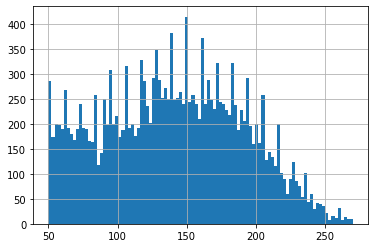

In [13]:
users_with_enough_activities_df["PreferenceScore"].hist(bins=100)

In [14]:
activities_from_selected_users_df = activities_df.merge(users_with_enough_activities_df[["UserId"]], 
               how = 'right',
               left_on = 'UserId',
               right_on = 'UserId')
activities_from_selected_users_df.shape

(989047, 4)

In [15]:
activities_from_selected_users_df

,RepositoryId,UserId,ActivityType,PreferenceScore
0,1,2044,Star,1
1,22197,2044,Fork,5
2,78682,2044,Fork,5
3,82282,2044,Star,1
4,96577,2044,Star,1
...,...,...,...,...
989042,261579047,19292,Fork,5
989043,263364626,19292,Fork,5
989044,267634594,19292,Watch,3
989045,267659215,19292,Fork,5


### Repositories EDA and cleaning



In [16]:
repositories_df[0:5]

,Id,Name,Description,Languages,OwnerId,CreatedAt,UpdatedAt
0,26899533,30daysoflaptops.github.io,NaN,"CSS, JavaScript",1,2014-11-20T06:42:06Z,2020-08-06T18:02:15Z
1,17358646,asteroids,"Destroy your Atom editor, Asteroids style!","CoffeeScript, CSS, JavaScript",1,2014-03-03T07:40:00Z,2020-06-19T17:58:20Z
2,29941343,benbalter.github.com,The personal website of Ben Balter. Built usin...,"CoffeeScript, CSS, Perl, Ruby, Shell",1,2015-01-27T23:54:05Z,2019-10-28T14:07:14Z
3,330651,bert,BERT (Binary ERlang Term) serialization librar...,"C, Ruby",1,2009-10-08T06:06:25Z,2020-07-22T22:38:46Z
4,444244,bert.erl,Erlang BERT encoder/decoder,Erlang,1,2009-12-21T02:10:34Z,2020-08-30T00:15:45Z


In [17]:
repositories_df = repositories_df[["Id", "Name", "Description"]]
repositories_df[0:2]

,Id,Name,Description
0,26899533,30daysoflaptops.github.io,NaN
1,17358646,asteroids,"Destroy your Atom editor, Asteroids style!"


In [18]:
# Leave only unique repositoryIds.
repositories_df = repositories_df.drop_duplicates("Id")
repositories_df.shape

(833704, 3)

### Final Cleaning

In [19]:
print(activities_from_selected_users_df.shape)
final_activities = activities_from_selected_users_df.merge(repositories_df,
              how = 'right',
              left_on = 'RepositoryId',
              right_on = 'Id')
print(final_activities)

(989047, 4)
         RepositoryId  ...                                        Description
0                 1.0  ...  **Grit is no longer maintained. Check out libg...
1                 1.0  ...  **Grit is no longer maintained. Check out libg...
2                 1.0  ...  **Grit is no longer maintained. Check out libg...
3                 1.0  ...  **Grit is no longer maintained. Check out libg...
4                 1.0  ...  **Grit is no longer maintained. Check out libg...
...               ...  ...                                                ...
1110295           NaN  ...                                                NaN
1110296           NaN  ...                                                NaN
1110297           NaN  ...  Part of gocc, is responsible for creating meas...
1110298           NaN  ...                                                NaN
1110299           NaN  ...                            Wrapper for Mishiko API

[1110300 rows x 7 columns]


In [20]:
activities_from_selected_users_df.UserId.value_counts()

33314    90
20421    90
8634     90
3252     90
32542    90
         ..
31739    10
15136    10
27892    10
11649    10
22888    10
Name: UserId, Length: 18603, dtype: int64

In [21]:
final_activities_count_df = final_activities.groupby('UserId').sum().reset_index()[["UserId", "PreferenceScore"]]
final_activities_count_df = final_activities_count_df[final_activities_count_df["PreferenceScore"]>=50]
final_users_with_enough_activities_df = final_activities_count_df[final_activities_count_df["PreferenceScore"]>=50]

print('# users after filtering:', final_users_with_enough_activities_df.shape[0])
print('# activities after filtering:', final_activities_count_df.shape[0])

# users after filtering: 18603
# activities after filtering: 18603


In [22]:
final_activities = final_activities.merge(final_users_with_enough_activities_df[["UserId"]], 
               how = 'right',
               left_on = 'UserId',
               right_on = 'UserId')
print('# Activities after final filtering:', final_activities.shape[0])

# Activities after final filtering: 989047


In [23]:
activities_train_df, activities_test_df = train_test_split(final_activities,
                                   stratify=final_activities['UserId'], 
                                   test_size=0.30,
                                   random_state=13)

print('# activities on Train set: %d' % len(activities_train_df))
print('# activities on Test set: %d' % len(activities_test_df))

# activities on Train set: 692332
# activities on Test set: 296715


# Content Based Recommender

In [24]:
# train set is at activities_train_df. 
# test set is at activities_test_df.

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
stopwords_list = stopwords.words('english')

vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     #min_df=0.005,
                     #max_df=0.5,
                     max_features=1000,
                     stop_words=stopwords_list)

item_ids = repositories_df['Id'].tolist()
tfidf_matrix = vectorizer.fit_transform(repositories_df['Name'].apply(lambda x: np.str_(x)) + " " + repositories_df['Description'].apply(lambda x: np.str_(x)))
tfidf_feature_names = vectorizer.get_feature_names()

In [28]:
print(tfidf_matrix.shape)
print(tfidf_feature_names)

(833704, 1000)
['10', '2013', '2d', '3d', 'abstraction', 'access', 'account', 'across', 'action', 'actions', 'active', 'activerecord', 'adapter', 'add', 'adding', 'addon', 'adds', 'admin', 'advanced', 'agent', 'ai', 'ajax', 'algorithm', 'algorithms', 'allow', 'allows', 'also', 'alternative', 'amazon', 'analysis', 'analytics', 'android', 'angular', 'angularjs', 'animation', 'another', 'ansible', 'ansible role', 'apache', 'api', 'api client', 'apis', 'app', 'apple', 'application', 'applications', 'apps', 'architecture', 'archive', 'arduino', 'around', 'art', 'asset', 'assets', 'async', 'asynchronous', 'atom', 'attributes', 'audio', 'auth', 'authentication', 'auto', 'automate', 'automated', 'automatic', 'automatically', 'automatically exported', 'automation', 'available', 'awesome', 'aws', 'aws lambda', 'azure', 'babel', 'back', 'backbone', 'backed', 'backend', 'background', 'backup', 'bar', 'base', 'based', 'bash', 'basic', 'beautiful', 'best', 'better', 'big', 'binary', 'binding', 'bind

## Build User Profiles
The profiles are build from all the content with which the user has engaged by taking the scores in consideration

In [ ]:
# Calculate user profiles from the train dataset.
user_profiles = {}
for user_id in activities_train_df.UserId.unique():
  user_profile = None
  activities_person_df = activities_train_df[activities_train_df["UserId"]==user_id]
  all_scores = activities_person_df.PreferenceScore.sum()
  for index, row in activities_person_df.iterrows():
    repository_id = row["RepositoryId"]
    score = row["PreferenceScore"]
    if(user_profile==None):
      user_profile = tfidf_matrix[item_ids.index(repository_id)]*score/all_scores
    else:
      user_profile = scipy.sparse.vstack((user_profile,tfidf_matrix[item_ids.index(repository_id)]*score/all_scores))
  user_profiles[user_id] = user_profile

### Evaluate

In [ ]:
mrr = 0
for user_id in activities_train_df.UserId.unique():
  cosine_similarities = cosine_similarity(user_profiles[user_id], tfidf_matrix)
  #print(cosine_similarities)
  similar_indices = cosine_similarities.argsort().flatten()[-1000:]
  items_to_ignore = activities_train_df[activities_train_df["UserId"]==user_id]["RepositoryId"].values
  items_to_evaluate = activities_test_df[activities_test_df["UserId"]==user_id]["RepositoryId"].values
  similar_indices_filtered = list(filter(lambda x: item_ids[x] not in items_to_ignore, similar_indices))
  print("after filtering train set items for user ", user_id, " = ",len(similar_indices_filtered))
  
  first_rank = len(similar_indices_filtered);
  l = len(similar_indices_filtered);
  for i in range(l):
    if(item_ids[similar_indices_filtered[l-i-1]] in items_to_evaluate):
      first_rank = i+1;
      break;
  mrr =mrr+ 1/first_rank
  print("first rank = ",first_rank);
  print("number of train items=",len(items_to_ignore))
mrr = mrr / activities_train_df.UserId.nunique()
print("mrr = ",mrr)